# Explorary Data Analysis

In [52]:
# Import packages for data analysis and visualization
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Plotly visualizations
import chart_studio.plotly as py # Note that package plotly has been renamed as chart_studio
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Other Libraries
import time
from scipy.stats import norm

%matplotlib inline

data_path='../data/loan.csv' #change to your own folder of data

## Data Overview

In [2]:
# load data
df = pd.read_csv(data_path)
df.shape

/Users/xchen/opt/anaconda3/envs/ds_37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.



(2260668, 145)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Get a summarization of all features:

In [4]:
df_type = df.dtypes
df_ms = df.apply(lambda x: len(x)-len(x.dropna()), axis=0)
df_type=df_type.rename('dtype')
df_ms=df_ms.rename('#missing')

df_info = pd.concat([df_type, df_ms], axis=1)
df_info.sort_values(by='#missing',ascending=False,inplace=True)
# save to csv file in order to check missing values later on
#df_info.to_csv('data/missing_count.csv')

In [5]:
df_info

,dtype,#missing
id,float64,2260668
url,float64,2260668
member_id,float64,2260668
orig_projected_additional_accrued_interest,float64,2252242
hardship_length,float64,2250055
...,...,...
out_prncp_inv,float64,0
out_prncp,float64,0
initial_list_status,object,0
hardship_flag,object,0


There are 145 features in total. First, we drop some empty/redundant columns:

In [6]:
deleted_cols = ['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title']
df.drop(deleted_cols, axis=1, inplace=True)

For a better understanding of the remaining features, I divide them into eight categories:

* <b>Loan Status</b> divides loans into nine categories. This is our target variable. We can determine the loans that are bad from <b>loan_status</b> column, and we aim to predict if the loan is good or not.
* <b>Account status</b> describes the basic characteristics of loan accounts and products, e.g. loan amount, term, interest rate, grade, issued date, purpose, etc.
* <b>Account behavior</b> descirbes borrowing and lending behaviors of given accounts, e.g. outstanding principal, total payment, last month payment, etc.
* <b>Customer information</b> describes customers' basic information such as employment, address, home ownership etc.
* <b>Customer credit information</b> describes customers' financial status that may affect willingness and capacity to repay. There are 67 variables in this category including debt-to-income ratios, deliquencies, inquiries, openning acounts, public records, ratings, collection trades, installment trades, revolving trades, utilization ratios, credit balances etc.
* <b>Co-borrow information</b> describes the characteristics for joint application accounts including joint financial status and status of co-borrowers. Only joint application accounts have values
* <b>Hardship information</b> describes features of hardship plan. Only accounts on a hardship plan have values.
* <b>Debt settlement plan</b> describes features of debt settlement. Only accounts working with debt settlement have values.

More detailed explanations can be found in [LCDataDictionary.xlsx](../data/LCDataDictionary.xlsx). In the following part, we visualize some features so as to 
1. get familiar with the loan business from both operational and risky sides; 
2. discover features that affact <b>loan_status</b> significantly; 
3. discover the reason of missing values and determine how to impute them.

## Loan Amount Distribtuion

First, let's study the distributions of three types of loan amount, namely, the ammount applied by the borrower, the amount committed to that loan and the ammount funded by investors. 
<h4>What we can learn:</h4>

* All of three are multinomial distributions. 
* The loan ammounts are in the range of 5000 to 20000 USD.
* The three distributions are quite similiar, which means most applied loans that meet requirements are approved and the loan funds are mainly from investors. The findings are consistent with the business model of Lending Club.

Text(0.5, 1.0, 'Total Funded by Investors')

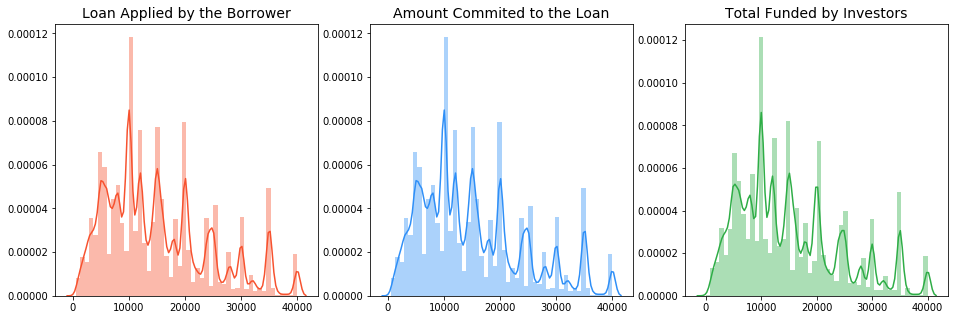

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amnt"].values
funded_amount = df["funded_amnt"].values
investor_funds = df["funded_amnt_inv"].values

sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Commited to the Loan", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total Funded by Investors", fontsize=14)

Then, we plot the average funded amount by each year. 
<h4> What we can learn:</h4>

* The year of 2018 was the year that most loans were issued.
* Loans were issued in an incremental manner before 2015, dereased in the following two years and peaked in 2018. (reflect the recovery of economy and a rapid growth of P2P industry)

In [8]:
# Transform the issue dates by year.
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

Text(0, 0.5, 'Average loan amount committed')

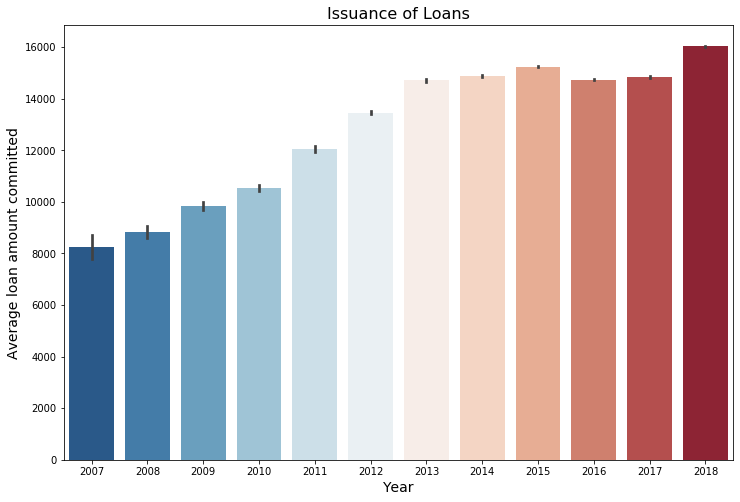

In [9]:
# The year of 2018 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=df, palette='RdBu_r')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount committed', fontsize=14)

## Loan Conditions

There are nine types of loan status. Furthermore, we decide load condition from the loan status, namely, good loans and bad loans. Note that the current loans may default in the future, which may lead our estimation inaccurate. However, current loans hold 40% of data, so we keep them in case of losing information. We can regard current loans as "good loans" and evaluate the prediction results separately from other determined types. 

In [10]:
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [11]:
df['loan_status'].value_counts()[1]/df.shape[0]

0.40682444304072957

In [12]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
df['loan_condition'] = np.nan   
df['loan_condition'] = df['loan_status'].apply(loan_condition)

First, we study the percentage of the loan condition (good/bad) by year.

<h4>What we can learn:</h4>

* The total percentage of bad loans is 13.14%.
* The percentage of bad loans increased before 2015 and decreased later, which means the quick development of loan business was on the cost of asset quality before 2015. But later on, the quality improved and the business became healthier.

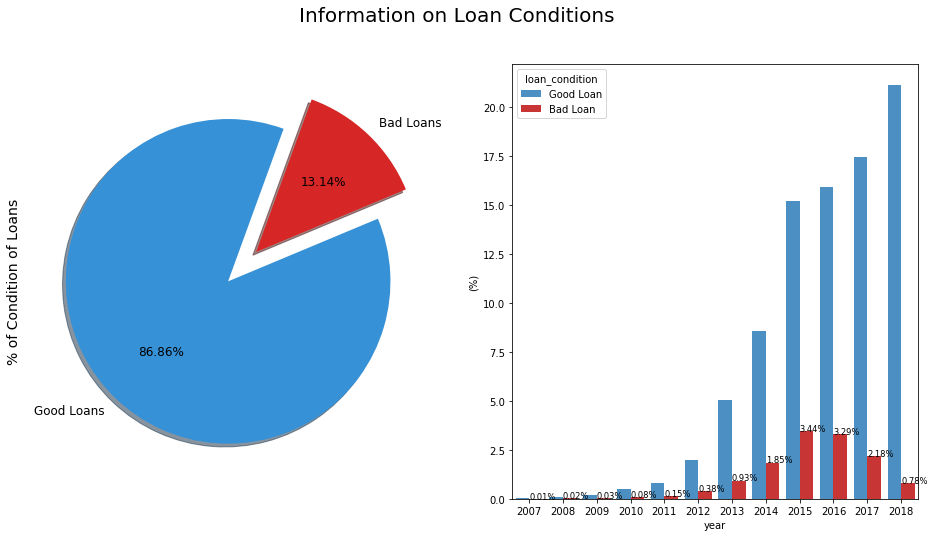

In [13]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)

ax[0].set_ylabel('% of Condition of Loans', fontsize=14)
palette = ["#3791D7", "#E01E1B"]

g=sns.barplot(x="year", y="funded_amnt", hue="loan_condition", data=df, palette=palette, 
            estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

bad_perc = df.loc[df['loan_condition']=='Bad Loan'].groupby('year').apply(lambda x: 100*len(x)/len(df)).reset_index()
bad_perc.rename(columns={0:'bad_perc'},inplace=True)

for index, row in bad_perc.iterrows():
    g.text(row.name,row.bad_perc, '%.2f%%'%(row.bad_perc), color='black', ha="left",fontsize='smaller')
    #{:.2f}%'.format(row.bad_perc)

Now we study the effect of factors involving regions, interest rates, grades, dti, incomes, employment lengths in perspective of loan ammounts and loan conditions.

## Region Pattern

We divide all stated into five regions and study the region patterns from two perspectives.

<h4> Regional pattern of loan amounts and percentage of bad loans:</h4>

* The issued loan amounts of <b>Southeast</b>, <b>Northeast</b> and <b>West</b> regions are generally higher than the other two regions, <b>Mid West</b> and <b> South West</b>.
* Correspondingly, the percentage of bad loans of <b>Southeast</b>, <b>Northeast</b> and <b>West</b> regions are also higher.
* The amount distributions are similiar among five regions.

In [14]:
df['addr_state'].unique()

array(['NY', 'LA', 'MI', 'WA', 'MD', 'IN', 'IL', 'FL', 'CT', 'GA', 'UT',
       'NC', 'KY', 'OH', 'AR', 'OK', 'CA', 'WV', 'NJ', 'SC', 'TX', 'PA',
       'KS', 'AL', 'VA', 'MO', 'AZ', 'NM', 'CO', 'RI', 'WI', 'TN', 'NV',
       'MA', 'NE', 'MN', 'NH', 'OR', 'VT', 'DC', 'MS', 'ID', 'DE', 'ND',
       'HI', 'ME', 'AK', 'WY', 'MT', 'SD', 'IA'], dtype=object)

In [15]:
# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(finding_regions)

In [16]:
# This code will take the current date and transform it into a year-month format
df['complete_date'] = pd.to_datetime(df['issue_d'])

group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['funded_amnt'] = group_dates['funded_amnt']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','funded_amnt']])

Text(0.5, 1.0, 'Monthly Loan Amounts Issued by Region')

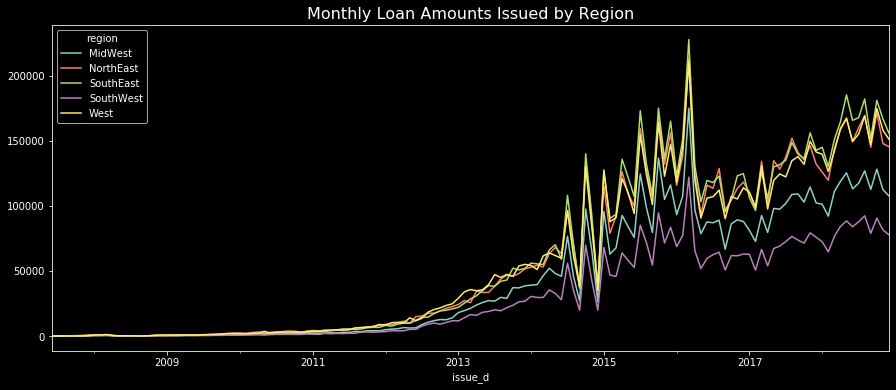

In [17]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).funded_amnt.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Monthly Loan Amounts Issued by Region', fontsize=16)

In [18]:
#df['issued_ym'] = [month.to_period('M') for month in df['complete_date']]
#df_condition = df.groupby(['issued_ym', 'region','loan_condition'], as_index=False)['funded_amnt'].sum()
#df_condition['funded_amnt'] = df_condition['funded_amnt']/1000

In [19]:
#plt.style.use('dark_background')

#cmap = plt.cm.Set3

#by_amnt_ratio = df_condition.groupby(['issued_ym', 'region']).apply(
#    lambda x: x.loc[x['loan_condition']=='Bad Loan','funded_amnt'].sum()/x['funded_amnt'].sum())
#by_amnt_ratio = pd.concat([by_issued_amount,by_amnt_ratio],axis=1).iloc[:,1]
#by_amnt_ratio.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))
#plt.title('Monthly Bad Loan Amount Ratio by Region', fontsize=16)

In [20]:
percentage_loan_contributor = pd.crosstab(df['region'], df['loan_condition']).apply(lambda x: x/x.sum() * 100)
percentage_loan_contributor['Bad Loan']

region
MidWest      17.156680
NorthEast    23.463050
SouthEast    25.107648
SouthWest    12.181138
West         22.091485
Name: Bad Loan, dtype: float64

[Text(0, 0.5, '(%)')]

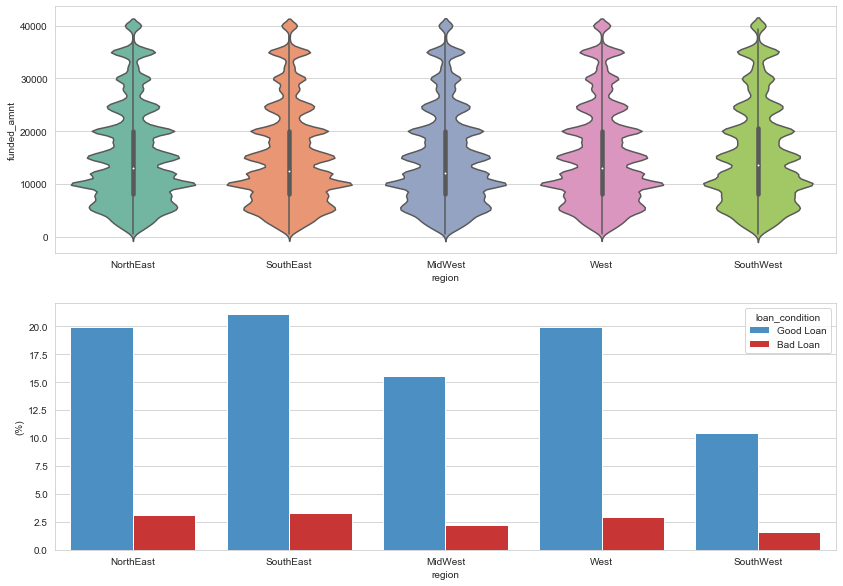

In [21]:
sns.set_style('whitegrid')
fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(14,10))

sns.violinplot(x="region", y="funded_amnt", data=df, palette="Set2", ax=ax1 )

palette = ["#3791D7", "#E01E1B"]
g=sns.barplot(x="region", y="funded_amnt", hue="loan_condition", data=df, palette=palette, 
            estimator=lambda x: len(x) / len(df) * 100)
ax2.set(ylabel="(%)")


<h4> Regional pattern of interest rates and customer characteristics</h4>

* The average interest rates of <b>southeast</b> and <b>northeast</b> regions are relatively higher than others. As mentioned above, percentage of bad loans in these two regions are higher too. But the difference of interest rates among region are very slight.
* The dti ratios of <b>Southwest</b>, <b>Midwest</b> and <b>Southest</b> regions tend to be higher than that of <b>West</b> and <b>Northeast</b> regions.
* Customers from <b>Midwest</b> and <b>Northeast</b> regions tend to have longer employment lengths, while customers from <b>Northeast</b>, <b>West</b> and <b>Southwest</b> regions have more income.

In [22]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

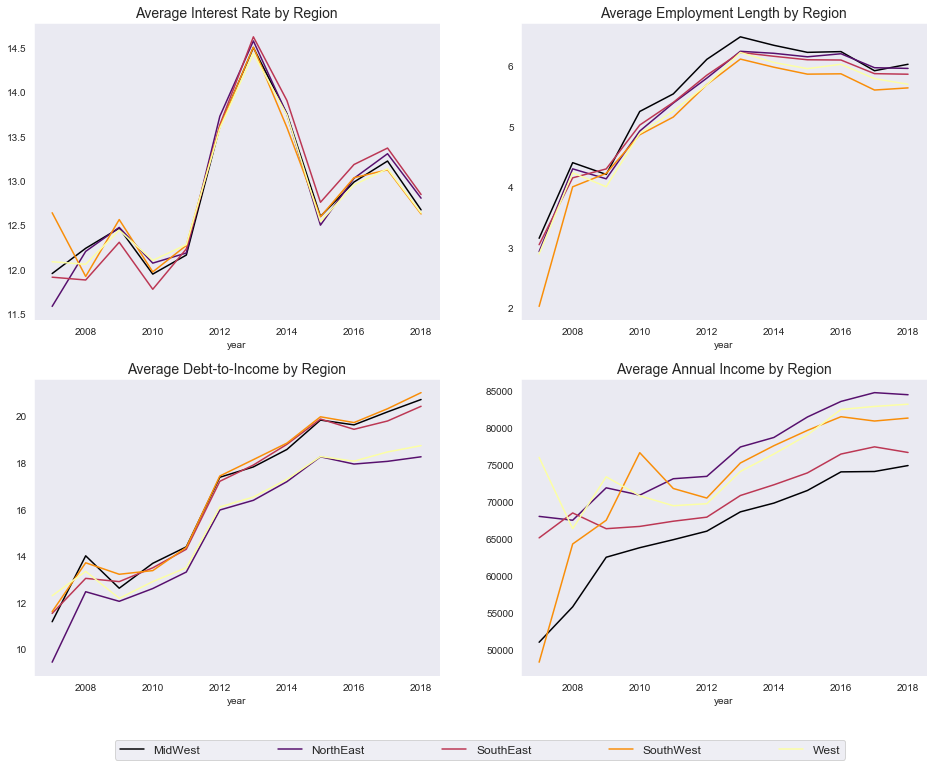

In [23]:
sns.set_style('darkgrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df.groupby(['year', 'region']).int_rate.mean()
by_interest_rate.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df.groupby(['year', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

by_dti = df.groupby(['year', 'region']).dti.mean()
by_dti.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df.groupby(['year', 'region']).annual_inc.mean()
by_income.unstack().plot(stacked=False, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.3, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

Now let's look at the risk pattern at each state.
* The most states that issued the most amount of loans are: <b>Califorlia</b>, <b>Texas</b>, <b>New York</b> and <b> Florida</b>. 
* Again, the average interest rates among states are almost the same.
* <b>Lowa</b> had the largest bad loan ratio but its loan amount is quite small and there are only 3 bad loans. 
* Most of the remaining states have similar bad loan ratios between 10% and 15%.

In [24]:
# Plotting by states

# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = df.groupby(['region','addr_state'], as_index=False).funded_amnt.sum()
by_interest_rate = df.groupby(['region', 'addr_state'], as_index=False).int_rate.mean()
by_income = df.groupby(['region', 'addr_state'], as_index=False).annual_inc.mean()



# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['funded_amnt'].values.tolist()
average_interest_rates = by_interest_rate['int_rate'].values.tolist()
average_annual_income = by_income['annual_inc'].values.tolist()


from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('int_rate', average_interest_rates),
                            ('annual_inc', average_annual_income)])
                     

metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()


# Think of a way to add default rate
# Consider adding a few more metrics for the future

,state_codes,issued_loans,int_rate,annual_inc
0,IA,112800,12.63,44756.21
1,IL,1410059775,12.96,79884.92
2,IN,550766125,13.18,70365.19
3,KS,283797100,13.00,71456.55
4,MI,841400600,13.16,71660.97


In [25]:
metrics_df.sort_values('annual_inc',ascending=False)

,state_codes,issued_loans,int_rate,annual_inc
24,DC,84617525,12.58,94553.07
17,NJ,1315538050,12.99,89920.51
14,MD,856563300,13.24,86919.01
12,CT,547351900,13.05,86531.03
34,VA,1012674150,13.11,86071.97
41,CA,4806351950,12.98,83847.98
13,MA,811425700,12.68,82788.66
39,TX,2930155075,13.00,82728.81
18,NY,2766038050,13.26,81057.05
1,IL,1410059775,12.96,79884.92


In [26]:
# Now it comes the part where we plot out plotly United States map

for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['int_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_inc'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]


layout = dict(
    title = 'Lending Clubs Issued Loans <br> (A Perspective for the Business Operations)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [27]:
by_condition = df.groupby('addr_state')['loan_condition'].value_counts()/ df.groupby('addr_state')['loan_condition'].count()
by_emp_length = df.groupby(['region', 'addr_state'], as_index=False).emp_length_int.mean().sort_values(by="addr_state")

loan_condition_bystate = pd.crosstab(df['addr_state'], df['loan_condition'] )

cross_condition = pd.crosstab(df["addr_state"], df["loan_condition"])
# Percentage of condition of loan
percentage_loan_contributor = pd.crosstab(df['addr_state'], df['loan_condition']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Bad Loan"]/(cross_condition["Good Loan"]+cross_condition["Bad Loan"])
by_dti = df.groupby(['region', 'addr_state'], as_index=False).dti.mean()
state_codes = sorted(states)


# Take to a list
bad_ratio = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = by_emp_length["emp_length_int"].values.tolist()
number_of_badloans = loan_condition_bystate['Bad Loan'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Bad Loan'].values.tolist()


# Figure Number 2
risk_data = OrderedDict([('state_codes', state_codes),
                         ('bad_ratio', bad_ratio),
                         ('badloans_amount', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_dti', average_dti),
                         ('average_emp_length', average_emp_length)])


# Figure 2 Dataframe 
risk_df = pd.DataFrame.from_dict(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.head()

,state_codes,bad_ratio,badloans_amount,percentage_of_badloans,average_dti,average_emp_length
0,AK,0.133,696,0.234,13.656,6.136
1,AL,0.158,4308,1.450,18.739,6.463
2,AR,0.155,2642,0.889,20.327,6.254
3,AZ,0.131,7028,2.366,20.414,5.680
4,CA,0.135,42319,14.247,19.240,5.947


In [28]:
for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_amount'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_dti'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['bad_ratio'], 
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Lending Clubs Default Rates <br> (Analyzing Risks)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

In [29]:
risk_df_ = risk_df
risk_df_.loc[risk_df_['state_codes']=='IA','bad_ratio']=0

In [30]:
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df_['bad_ratio'], 
        locationmode = 'USA-states',
        text = risk_df_['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Lending Clubs Default Rates <br> (Excluding Lowa)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

## Correlation Analysis

Now let's look at how these factors affact each other via correlation analysis. We calculated Kedall's tau correlation coefficients between every two factors of interest. Kedall's tau measures the similarity of the orderings of the data when ranked by each of the two factors. So the value of Kendall's tau will be large if two factors have similar rank distributions. We selected some typical factors in each feature category that described in [LCDataDictionary.xlsx](../data/LCDataDictionary.xlsx). From the correlation analysis, we hope to find the key factors of loan condition. Meanwhile, we can get some insights about how Lending Club made decisions in terms of loan amount, interest rate and grade.
<h4> What we can learn:</h4>

* Factors correlated with <b>loan status</b> include <b>grade</b> (0.20), <b>interest rate</b> (0.17), <b>outstanding principal</b> (0.20), <b>total payment</b> (0.11), <b>total received principal</b> (0.20), <b>total received late fee</b> (0.22), <b>post charge-off recovery</b> (0.74)</b>, <b>post charge-off collection fee</b> (0.72). 
* It shows that loan status is highly correlated with customers' repay behaviors such as payment, recovery, collection, etc. Conversely, factors, such as <b>annual income</b>, <b> employment length</b>, <b>dit</b>, <b>balance</b>, <b>credit utilization</b>, have low correlation with bad loans.
* However, <b>funded amount</b> is correlated with annual income, revolved balance, average current balance, as well as outstanding principal, total payment, total received principal/interest, totoal account and open account.
* <b>Grades</b> and <b>interest rates</b> are high correlated with a coefficient of 0.86. Meanwhile, dti, utility, recoveries, inquries, etc.
* The correlation result shows that most of features in the same category are correlated with each other, which 

In [31]:
grade = ['A', 'B','C','D','E','F','G']

# Create a new column and convert emp_length to integers.

df['grade_int'] = np.nan
for i, g in enumerate(grade):
    df.loc[df['grade']==g,'grade_int']=i

df['loan_condition_int'] = 1
df.loc[df['loan_condition']=='Good Loan','loan_condition_int']=0

In [32]:
df_factor = df[['loan_condition_int','funded_amnt','grade_int','int_rate', 
                'annual_inc', 'emp_length_int',
                'dti','revol_bal', 'avg_cur_bal',
                'revol_util', 'all_util','il_util','bc_util',
                'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                'delinq_2yrs', 'mths_since_last_delinq', 'acc_now_delinq','delinq_amnt',
                'inq_last_6mths', 
                'total_acc','open_acc', 
                'pub_rec', 'mths_since_last_record',
                'chargeoff_within_12_mths','tax_liens'
               ]]

In [33]:
# For the Pearson r correlation, both variables should be normally distributed. 
# Other assumptions include linearity and homoscedasticity.  
# Linearity assumes a straight line relationship between each of the two variables 
# homoscedasticity assumes that data is equally distributed about the regression line.
df_correlations = df_factor.corr()# pearson

In [34]:
# Kendall rank correlation is a non-parametric test that measures the similarity of the orderings 
# of the data when ranked by each of the quantities. 
df_correlations_ = df_factor.corr(method = 'kendall')# kendall

In [39]:
# Spearman rank correlation is a non-parametric test 
# that measures how well the relationship between two variables can be described using a monotonic function.
df_correlations_s = df_factor.corr(method = 'spearman')

In [35]:
# In the normal case, the Kendall correlation is preferred than the Spearman correlation and Pearson correlation
# because of a smaller gross error sensitivity (GES) (more robust) and a smaller asymptotic variance (AV) (more efficient).
# see https://www.cnblogs.com/sherrydatascience/p/12406467.html for more details.
trace = go.Heatmap(z=df_correlations_.values,
                   x=df_correlations_.columns,
                   y=df_correlations_.columns,
                   zmin=-1.0,
                   zmax=1.0,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.95,0,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
            )
                  )

layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

In the following section, we will implement an in-depth analysis to determine pattens that will allow us to understand somehow factors that contribute to a bad loan being.

<h4>Impact of grade:</h4>

* Users with <b>higher grade</b>(e.g. F, G.) tend to have more loan funded.
* Most of loans are issued to users ranked as B and C.
* The higher the grade, the larger the pencentage of bad loans, and hence the larger the interest rate. So users with higher grades are more risky.
* Bad loans have larger average interest rate than good loans.

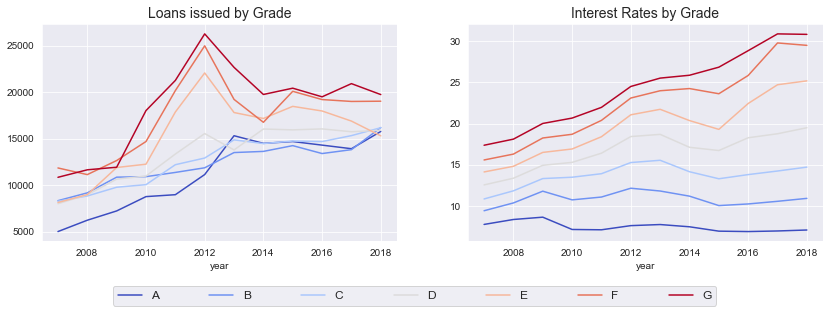

In [59]:
# Let's visualize how many loans were issued by grade
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amnt.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Grade', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).int_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Grade', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

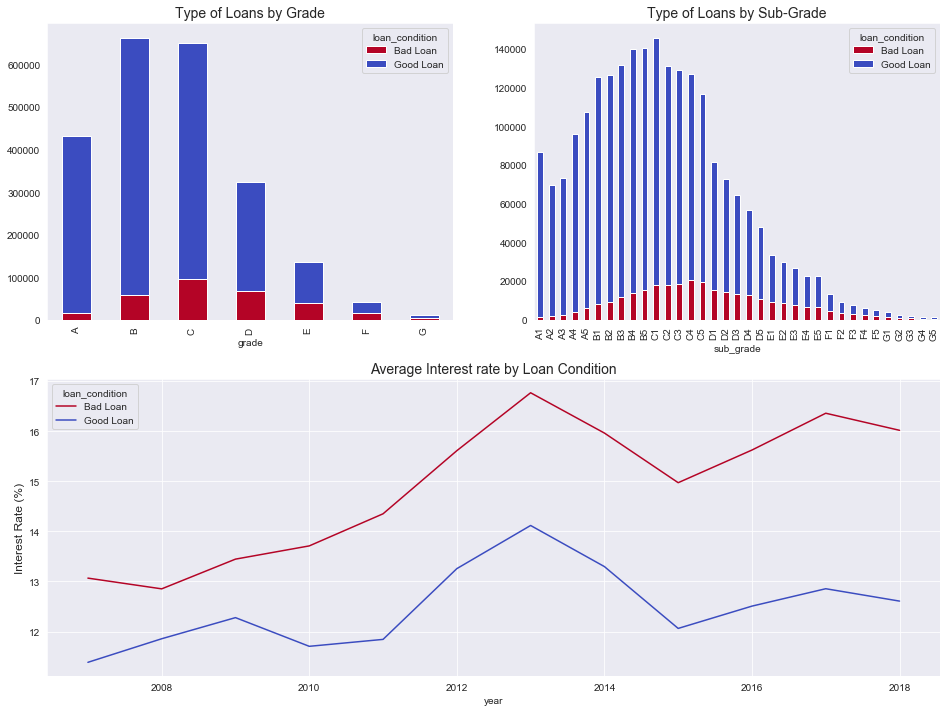

In [69]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).int_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

<h4>Impact of interest rate:</h4>

* Using the overall average interest rate as a threshold, we divide interest rate into low and high.
* The longer of the maturity, the higher of the interest rate.
* Users with low interest rates have higher percentage of bad loans.


In [38]:
df['int_rate'].describe()

count    2.260668e+06
mean     1.309291e+01
std      4.832114e+00
min      5.310000e+00
25%      9.490000e+00
50%      1.262000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

In [45]:
# Average interest is 13.09% Anything above this will be considered of high risk let's see if this is true.
df['interet_payments'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['int_rate'] <= 13.09, 'interet_payments'] = 'Low'
    col.loc[col['int_rate'] > 13.09, 'interet_payments'] = 'High'
    
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,settlement_term,year,loan_condition,region,complete_date,emp_length_int,grade_int,loan_condition_int,interest_payments,interet_payments
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,10+ years,RENT,...,NaN,2018,Good Loan,NorthEast,2018-12-01,10.0,2.0,0,High,High
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,10+ years,MORTGAGE,...,NaN,2018,Good Loan,SouthEast,2018-12-01,10.0,3.0,0,High,High
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,6 years,MORTGAGE,...,NaN,2018,Good Loan,MidWest,2018-12-01,6.0,3.0,0,High,High
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,10+ years,MORTGAGE,...,NaN,2018,Good Loan,West,2018-12-01,10.0,3.0,0,High,High
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,10+ years,MORTGAGE,...,NaN,2018,Good Loan,NorthEast,2018-12-01,10.0,2.0,0,High,High


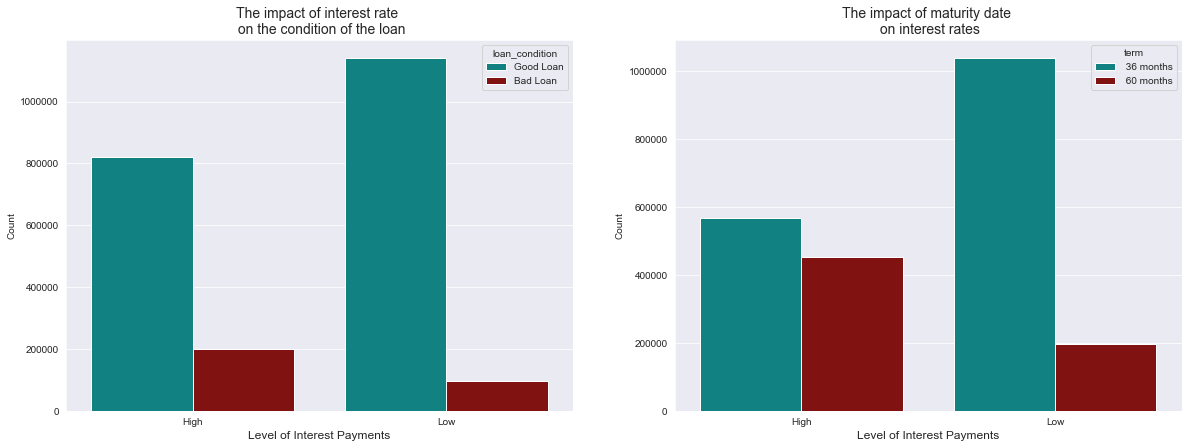

In [70]:
plt.figure(figsize=(20,15))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=df, 
                  palette=palette, hue='loan_condition')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=df, 
                   palette=palette, hue='term')

ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')


# plt.subplot(212)
# low = df['loan_amnt'].loc[df['interest_payments'] == 'Low'].values
# high = df['loan_amnt'].loc[df['interest_payments'] == 'High'].values


# ax2= sns.distplot(low, color='#009393', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
# ax3 = sns.distplot(high, color='#930000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
# plt.axis([0, 36000, 0, 0.00016])
# plt.legend()


plt.show()

<h4> The impact of home ownership:</h4>

* Among all types of home ownership, mortgage users have the highest amount of bad loans.
* Mortgage users are more like to apply for a loan.

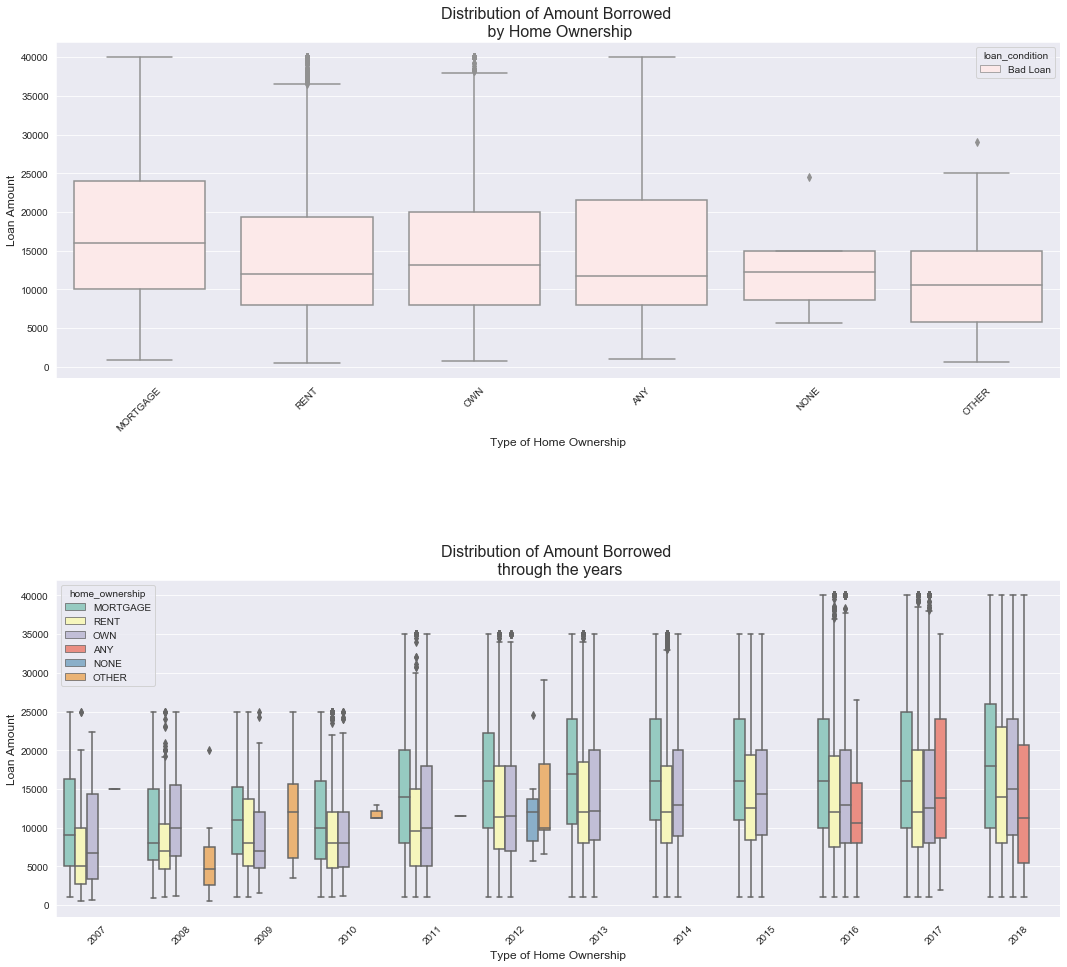

In [51]:
plt.figure(figsize=(18,18))

# Create a dataframe for bad loans
bad_df = df.loc[df['loan_condition'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='funded_amnt', hue='loan_condition',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)



plt.subplot(212)
g1 = sns.boxplot(x='year', y='funded_amnt', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the years", fontsize=16)


plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

# Missing Values

In [72]:
df[df['last_pymnt_d'].isna()]['loan_status'].value_counts()

Charged Off                                            2260
Late (31-120 days)                                      153
Does not meet the credit policy. Status:Charged Off      12
Default                                                   1
Name: loan_status, dtype: int64

In [73]:
df[df['last_pymnt_d'].isna()][['loan_status','last_pymnt_amnt','last_pymnt_d']]

,loan_status,last_pymnt_amnt,last_pymnt_d
1777,Late (31-120 days),0.0,NaN
3203,Late (31-120 days),0.0,NaN
3677,Late (31-120 days),0.0,NaN
4022,Late (31-120 days),0.0,NaN
4768,Late (31-120 days),0.0,NaN
...,...,...,...
2258502,Charged Off,0.0,NaN
2259567,Charged Off,0.0,NaN
2259678,Charged Off,0.0,NaN
2260408,Charged Off,0.0,NaN


In [74]:
df[df['next_pymnt_d'].isna()]['loan_status'].value_counts()

Fully Paid     1041952
Charged Off     261655
Name: loan_status, dtype: int64

In [75]:
df[df['next_pymnt_d'].isna()]['last_pymnt_d'].isna().sum()

2260

In [76]:
df[['last_pymnt_d','next_pymnt_d','term','issue_d','out_prncp','loan_amnt']]

,last_pymnt_d,next_pymnt_d,term,issue_d,out_prncp,loan_amnt
0,Feb-2019,Mar-2019,36 months,Dec-2018,2386.02,2500
1,Feb-2019,Mar-2019,60 months,Dec-2018,29387.75,30000
2,Feb-2019,Mar-2019,36 months,Dec-2018,4787.21,5000
3,Feb-2019,Mar-2019,36 months,Dec-2018,3831.93,4000
4,Feb-2019,Mar-2019,60 months,Dec-2018,29339.02,30000
...,...,...,...,...,...,...
2260663,Feb-2019,Mar-2019,60 months,Oct-2017,8687.20,12000
2260664,Aug-2018,NaN,60 months,Oct-2017,0.00,12000
2260665,Feb-2019,Mar-2019,36 months,Oct-2017,5993.27,10000
2260666,Feb-2019,Mar-2019,60 months,Oct-2017,9924.69,12000


In [77]:
df[df['next_pymnt_d'].isna()][['issue_d','term','last_pymnt_d','out_prncp','loan_amnt','loan_status']].sort_values(by='issue_d')

,issue_d,term,last_pymnt_d,out_prncp,loan_amnt,loan_status
2138327,Apr-2008,36 months,Apr-2011,0.0,2000,Fully Paid
2138300,Apr-2008,36 months,Jan-2010,0.0,7500,Fully Paid
2138301,Apr-2008,36 months,Apr-2011,0.0,7500,Fully Paid
2138302,Apr-2008,36 months,Apr-2011,0.0,7000,Fully Paid
2138303,Apr-2008,36 months,Apr-2011,0.0,7500,Fully Paid
...,...,...,...,...,...,...
155876,Sep-2018,60 months,Dec-2018,0.0,14000,Fully Paid
155879,Sep-2018,36 months,Nov-2018,0.0,8400,Charged Off
155916,Sep-2018,36 months,Jan-2019,0.0,9500,Fully Paid
155547,Sep-2018,36 months,Dec-2018,0.0,20000,Fully Paid


In [78]:
df[df['next_pymnt_d'].isna()]['out_prncp'].describe()

count    1303607.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: out_prncp, dtype: float64

In [79]:
df.loc[(df['out_prncp']==0)&(~df['next_pymnt_d'].isna())][['issue_d','term','last_pymnt_d','next_pymnt_d','loan_amnt','loan_status']].sort_values(by='issue_d')

,issue_d,term,last_pymnt_d,next_pymnt_d,loan_amnt,loan_status
2141184,Apr-2008,36 months,Mar-2010,Apr-2010,13000,Does not meet the credit policy. Status:Fully ...
2141159,Apr-2008,36 months,Apr-2011,May-2011,6000,Does not meet the credit policy. Status:Fully ...
2141160,Apr-2008,36 months,Sep-2008,Oct-2009,8000,Does not meet the credit policy. Status:Charge...
2141161,Apr-2008,36 months,Nov-2010,Mar-2011,5000,Does not meet the credit policy. Status:Charge...
2141162,Apr-2008,36 months,Mar-2011,Apr-2011,9250,Does not meet the credit policy. Status:Fully ...
...,...,...,...,...,...,...
137222,Sep-2018,36 months,Feb-2019,Mar-2019,10000,Current
137095,Sep-2018,60 months,Feb-2019,Mar-2019,17000,Current
136284,Sep-2018,36 months,Feb-2019,Mar-2019,11000,Current
135691,Sep-2018,60 months,Feb-2019,Mar-2019,30000,Current


In [80]:
df[df['open_acc'].isna()][['loan_status','grade','earliest_cr_line','last_credit_pull_d','open_acc','total_acc','pub_rec','delinq_2yrs','inq_last_6mths']]

,loan_status,grade,earliest_cr_line,last_credit_pull_d,open_acc,total_acc,pub_rec,delinq_2yrs,inq_last_6mths
2141934,Does not meet the credit policy. Status:Fully ...,A,NaN,May-2007,NaN,NaN,NaN,NaN,NaN
2141935,Does not meet the credit policy. Status:Fully ...,A,NaN,May-2007,NaN,NaN,NaN,NaN,NaN
2141944,Does not meet the credit policy. Status:Fully ...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2141957,Does not meet the credit policy. Status:Fully ...,B,NaN,May-2007,NaN,NaN,NaN,NaN,NaN
2141965,Does not meet the credit policy. Status:Fully ...,A,NaN,May-2007,NaN,NaN,NaN,NaN,NaN
2141968,Does not meet the credit policy. Status:Fully ...,B,NaN,Feb-2019,NaN,NaN,NaN,NaN,NaN
2141979,Does not meet the credit policy. Status:Fully ...,C,NaN,May-2007,NaN,NaN,NaN,NaN,NaN
2141994,Does not meet the credit policy. Status:Fully ...,B,NaN,May-2007,NaN,NaN,NaN,NaN,NaN
2141999,Does not meet the credit policy. Status:Fully ...,B,NaN,Feb-2019,NaN,NaN,NaN,NaN,NaN
2142000,Does not meet the credit policy. Status:Fully ...,C,NaN,Jan-2017,NaN,NaN,NaN,NaN,NaN


In [81]:
df[df['open_acc'].isna()]['loan_status'].value_counts()

Does not meet the credit policy. Status:Fully Paid     26
Does not meet the credit policy. Status:Charged Off     3
Name: loan_status, dtype: int64

In [82]:
df.loc[df['loan_status']=='Does not meet the credit policy. Status:Fully Paid']['open_acc']

2139271     8.0
2139273    10.0
2139274     4.0
2139275     8.0
2139277     7.0
           ... 
2142015     NaN
2142016     NaN
2142017     NaN
2142018     NaN
2142019     NaN
Name: open_acc, Length: 1988, dtype: float64

In [83]:
df['emp_length'].value_counts()

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: emp_length, dtype: int64

In [85]:
df[['grade','sub_grade','revol_util','revol_util']]

,grade,sub_grade,revol_util,revol_util
0,C,C1,10.3,10.3
1,D,D2,24.2,24.2
2,D,D1,19.1,19.1
3,D,D2,78.1,78.1
4,C,C4,3.6,3.6
...,...,...,...,...
2260663,C,C3,39.2,39.2
2260664,E,E4,20.2,20.2
2260665,B,B5,70.9,70.9
2260666,D,D5,34.9,34.9


In [91]:
df['hardship_flag'].value_counts()

N    2259783
Y        885
Name: hardship_flag, dtype: int64

In [92]:
df.iloc[:,-23:-7]

,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,year,loan_condition
0,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan
1,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan
2,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan
3,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan
4,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2018,Good Loan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2017,Good Loan
2260664,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2017,Good Loan
2260665,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2017,Good Loan
2260666,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2017,Good Loan


In [93]:
df['hardship_type'].value_counts()

INTEREST ONLY-3 MONTHS DEFERRAL    10613
Name: hardship_type, dtype: int64

In [94]:
df['hardship_reason'].value_counts()

NATURAL_DISASTER         2965
EXCESSIVE_OBLIGATIONS    2079
UNEMPLOYMENT             1834
INCOME_CURTAILMENT       1279
MEDICAL                  1249
REDUCED_HOURS             629
DIVORCE                   218
FAMILY_DEATH              206
DISABILITY                154
Name: hardship_reason, dtype: int64

In [95]:
df['debt_settlement_flag'].value_counts()

N    2227612
Y      33056
Name: debt_settlement_flag, dtype: int64

In [96]:
df.iloc[:,-7:]

,region,complete_date,emp_length_int,grade_int,loan_condition_int,interest_payments,interet_payments
0,NorthEast,2018-12-01,10.0,2.0,0,High,High
1,SouthEast,2018-12-01,10.0,3.0,0,High,High
2,MidWest,2018-12-01,6.0,3.0,0,High,High
3,West,2018-12-01,10.0,3.0,0,High,High
4,NorthEast,2018-12-01,10.0,2.0,0,High,High
...,...,...,...,...,...,...,...
2260663,NorthEast,2017-10-01,10.0,2.0,0,High,High
2260664,West,2017-10-01,0.5,4.0,0,High,High
2260665,MidWest,2017-10-01,10.0,1.0,0,Low,Low
2260666,West,2017-10-01,NaN,3.0,0,High,High
